In [1]:
var azureOpenAIEndpoint = "";
var azureOpenAIKey = "";
var azureOpenAIModelId = "";
var azureOpenAIEmbeddingModelId = ";

var azureAISearchKey = "";
var azureAISearchEndpoint = "";

#### Semantic Kernel

Semantic Kernel is a lightweight, open-source development kit that lets you easily build AI agents and integrate the latest AI models into your C#, Python, or Java codebase. It serves as an efficient middleware that enables rapid delivery of enterprise-grade solutions.

**Resources:**

- [Microsoft Learn](https://learn.microsoft.com/en-us/semantic-kernel/overview/)
- [GitHub Repo](https://github.com/microsoft/semantic-kernel)

### Setting up the client

To invoke prompts we need to create a kernel instance. The kernel is the central component of Semantic Kernel. At its simplest, the kernel is a Dependency Injection container that manages all of the services and plugins necessary to run your AI application. If you provide all of your services and plugins to the kernel, they will then be seamlessly used by the AI as needed.This is extremely powerful, because it means you as a developer have a single place where you can configure, and most importantly monitor, your AI agents.

The cell below creates a kernel instance that allows us to invoke the Azure Open AI API.

In [2]:
#r "nuget: Microsoft.SemanticKernel, *-*"

using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.ChatCompletion;

// Generating images is experimental
#pragma warning disable SKEXP0010

var kernel = Kernel.CreateBuilder()
            .AddAzureOpenAIChatCompletion(
                azureOpenAIModelId,
                azureOpenAIEndpoint,
                azureOpenAIKey)
            .AddAzureOpenAITextToImage(
                azureOpenAIVisionModelId,
                azureOpenAIEndpoint,
                azureOpenAIKey)
            .Build();
var chatCompletionService = kernel.GetRequiredService<IChatCompletionService>();

### Lab 1: Chatting with the AI

In the previous step we configured the kernel. We added two components that will allow us to use the text completion capabilities and the text to image capability. The components we have added use the Azure Open AI API. Do note that you can also instead use a (local) model using Ollama, ONNX or other options. Throughout this workshop we will use the Azure Open AI API but remember that you can easily switch to a different model by changing the configuration.

The cell below will ask the user to provide a question and it will try to answer it using the GPT-4o model.
The second call demonstrates how to add user and system messages to the conversation.

In [16]:
var result = await chatCompletionService.GetChatMessageContentAsync("What color is the sky?"); 
Console.WriteLine(result); 

var chatPrompt = """
            <message role="user">What is Seattle?</message>
            <message role="system">Respond with JSON.</message>
            """;
result = await chatCompletionService.GetChatMessageContentAsync(chatPrompt); 
result 

**Exercises:**

- Inspect the output, what does it provide other than the actual response?
- Ask the AI to add two simple numbers together, what is the answer?
- Ask the AI, after answering the previous question, to add another number, what is the answer? How come?

### Lab 2: Introducing plugins

Chatting with the AI is fun, but we can also use it to do some more practical tasks. For that, we might want to reach into a backend system to get some data. In this case, we create a plugin that tells us the current directory, something that is not possible to do directly with the AI. 

First, we need to describe the function so the AI knows what action can be performed by the plugin. Then, we need to register the function with the AI.

In [25]:
using System.ComponentModel;
using Microsoft.SemanticKernel.Connectors.OpenAI;

// Define the plugin
public class WorkingDirectoryInformation
{
    [KernelFunction]
    [Description("Get the current working directory.")]
    public string GetCurrentDirectory() => Environment.CurrentDirectory;
}

// Create the kernel and register the plugin
var kernelBuilder = Kernel.CreateBuilder()
    .AddAzureOpenAIChatCompletion(
        azureOpenAIModelId,
        azureOpenAIEndpoint,
        azureOpenAIKey);

kernel = kernelBuilder.Build();
kernel.Plugins.AddFromType<WorkingDirectoryInformation>();
chatCompletionService = kernel.GetRequiredService<IChatCompletionService>();

#pragma warning disable SKEXP0001
OpenAIPromptExecutionSettings settings = new() { FunctionChoiceBehavior = FunctionChoiceBehavior.Auto() };

// Chat with the plugin
var result = await chatCompletionService.GetChatMessageContentAsync("Get the directory I am working in.", settings, kernel); 
Console.WriteLine(result); 
result

Now, when it comes to functions it is better to create several smaller chatbots that can answer specific questions for a specific domain than having one chatbot that has tens of functions. This way the AI can better understand the context and provide better answers. To orchestrate more complex flows an orchestrating chatbot could determine the intent and delegate the task to a specialized chatbot. In AI terms these kind of chatbots are called agents.

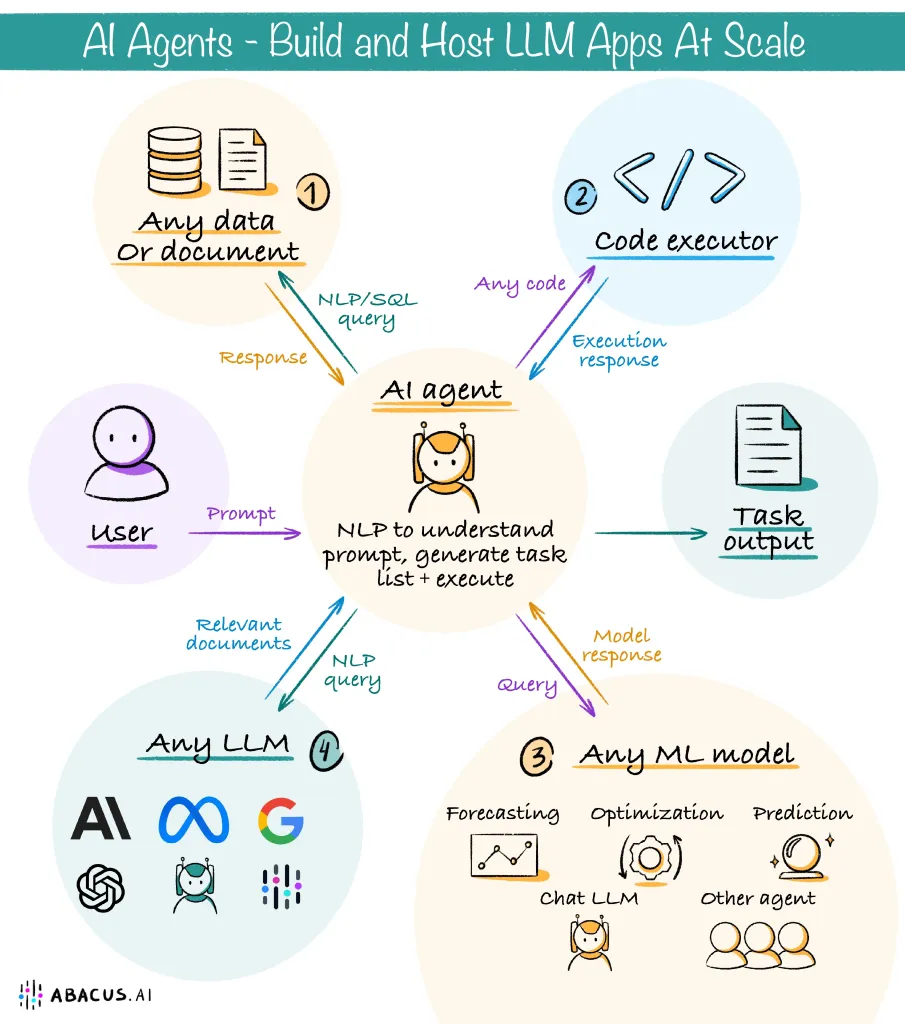

**Questions:**

- What possibilities do you see with this kind of technology for our organization?
- What needs to be done to make this a reality?
- What are the risks of using this technology?

### Lab 3: Adding a little bit of history

Imaging you are designing an agent that is supposed to help users with their daily tasks. You want to make sure that the agent can remember the context of the conversation. This is where the history comes in. Lets first try out what the default behavior is when dealing with LLMs. Run the cell below and closely observe the output. What does it tell you?

In [4]:
using Microsoft.SemanticKernel.ChatCompletion;

var history = new ChatHistory();

var chatPrompt = """
            <message role="system">Before you start a conversation you will ask the name of the user.</message>
            <message role="user">Hi there, can I ask you a question? How much is 2 + 2?.</message>
            """;
result = await chatCompletionService.GetChatMessageContentAsync(chatPrompt);
Console.WriteLine(result);
result = await chatCompletionService.GetChatMessageContentAsync("My name is John Doe, can you now please answer my question?");
Console.WriteLine(result);


The previous cell demonstrates an important aspect of LLMs, they do not have memory. We asked a question but also instructed . This means that the AI does not remember the context of the conversation. This is where the history comes in. The history is a way to store the context of the conversation so that the AI can refer back to it when needed. Lets try the same example as before but this time with the history enabled.

In [41]:
using Microsoft.SemanticKernel.ChatCompletion;

var chatHistory = new ChatHistory();
chatHistory.AddSystemMessage("Before you start a conversation you will ask the name of the user.");
chatHistory.AddUserMessage("Hi there, can I ask you a question? How much is 2 + 2?.");

result = await chatCompletionService.GetChatMessageContentAsync(chatHistory);
Console.WriteLine(result);

chatHistory.AddUserMessage("My name is John Doe, can you now please answer my question?");

result = await chatCompletionService.GetChatMessageContentAsync(chatHistory);
Console.WriteLine(result);


A few notes on history: when we add history to the mix do mind that it needs to be passed to the AI on every single call, which results in a higher token usage. This is something to keep in mind when designing your chatbot. You can mitigate this by only passing the relevant parts of the history to the AI, or to summarize the history or pass in the last n number of messages. In a more advanced scenario you could also use a vector database to store the history for the AI to access the relevant parts.

### Lab 4: Chat using complex messages

Some LLMs are so called multimodal models. Not only can the generate text based on a prompt, they can also describe images. This is a powerful feature that can be used in a variety of ways. In this lab we will use the multimodal capabilities of the AI to describe an image.

In [ ]:
using Microsoft.SemanticKernel.ChatCompletion;
using System.IO;

var imageBytes = await File.ReadAllBytesAsync(@".\..\deploy\assets\to-analyze.png");

var items = new ChatMessageContentItemCollection();
items.Add(new ImageContent(imageBytes, "image/png"));
items.Add(new TextContent("What can you tell me about this image?"));

var chatHistory = new ChatHistory();
chatHistory.AddUserMessage(items);

result = await chatCompletionService.GetChatMessageContentAsync(chatHistory);
Console.WriteLine(result);


### Lab 5: Generating images

In this lab we will use the AI to generate an image based on a prompt. Typically the size of the resulting image is rather small, this can be mitigated by passing the image to an upscaling model. 


In [ ]:
using Microsoft.SemanticKernel.TextToImage;

// Generating images is experimental
#pragma warning disable SKEXP0001

var imageService = kernel.GetRequiredService<ITextToImageService>();
var image = await imageService.GetImageContentsAsync(new TextContent("A dog on a sailboat"));
var imageContent = image.First().InnerContent as OpenAI.Images.GeneratedImage;
imageContent

Now aks yourself, can you think of a way to use this technology in our organization? What would be the benefits and what would be the risks?

### Lab 6: Adding Vector Stores

Vector databases have many use cases across different domains and applications that involve natural language processing (NLP), computer vision (CV), recommendation systems (RS), and other areas that require semantic understanding and matching of data. 

One use case for storing information in a vector database is to enable large language models (LLMs) to generate more relevant and coherent responses. For example, if you want to write a blog post about the latest trends in AI, you can use a vector database to store the latest information about that topic and pass the information along with the ask to a LLM in order to generate a blog post that leverages the latest information.

Semantic Kernel and .net provides an abstraction for interacting with Vector Stores and a list of out-of-the-box connectors that implement these abstractions. Features include creating, listing and deleting collections of records, and uploading, retrieving and deleting records. The abstraction makes it easy to experiment with a free or locally hosted Vector Store and then switch to a service when needing to scale up.

The Semantic Kernel Vector Store connectors use a model first approach to interacting with databases. All methods to upsert or get records use strongly typed model classes. The properties on these classes are decorated with attributes that indicate the purpose of each property.

## Lab scenario

For this workshop we want to create a chatbot that can help us make sense of the storyline and characters in the popular TV series Game of Thrones. In order to do this we will create a vector store that contains information about the characters and the storyline. We will then create a chatbot that can answer questions about the storyline and the characters.

First of all, we need a model to store the information about the characters and the storyline. To do that, run the cell below.

In [ ]:
public sealed class TextSnippet<TKey>
{
    [VectorStoreRecordKey]
    public required TKey Key { get; set; }

    [VectorStoreRecordData]
    public string Text { get; set; }

    [VectorStoreRecordData]
    public string ReferenceDescription { get; set; }

    [VectorStoreRecordData]
    public string ReferenceLink { get; set; }

    [VectorStoreRecordVector(1536)]
    public ReadOnlyMemory<float> TextEmbedding { get; set; }
}


Now we have the model we can configure the kernel. For this lab we will use an in-memory vector store. This is a simple key-value store that can be used to store information about the characters and the storyline. In a real-world scenario you would use a more advanced vector store like Azure Cosmos DB, SQLite, Qdrant or any of the [other supported vector stores](https://learn.microsoft.com/en-us/semantic-kernel/concepts/vector-store-connectors/out-of-the-box-connectors/?pivots=programming-language-csharp). 

We also need a text embedding service to vectorize the text so that we can store it in the vector store. Creating embeddings is an important step when using vector stores. Vector embeddings are a way to convert words and sentences and other data into numbers that capture their meaning and relationships. This is important because it allows us to compare and search for similar items in the vector store. In this lab we will use the Azure Open AI API to create the embeddings.

Finally we need a  Vector Store Text Search implementation that uses the Vector Store Connectors to retrieve search results (In this lab, the in-memory vector store). This means you can use Vector Store Text Search with any Vector Store which Semantic Kernel supports and any implementation of Microsoft.Extensions.VectorData.Abstractions.

After building the kernel we create an empty collection in the vector store to store the information about the characters and the storyline.

In [57]:
#r "nuget: Microsoft.SemanticKernel.Connectors.InMemory, *-*"

using Azure;
using Microsoft.Extensions.VectorData;
using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.Data;
using Microsoft.SemanticKernel.Embeddings;
using System.IO;

// Using memory is experimental
#pragma warning disable SKEXP0001, SKEXP0020, SKEXP0010

var kernelBuilder = Kernel.CreateBuilder()
    .AddAzureOpenAITextEmbeddingGeneration(
        azureOpenAIEmbeddingModelId,
        azureOpenAIEndpoint,
        azureOpenAIKey)
    .AddInMemoryVectorStoreRecordCollection<string, TextSnippet<string>>("data")
    .AddVectorStoreTextSearch<TextSnippet<string>>(
        new TextSearchStringMapper((result) => (result as TextSnippet<string>)!.Text!),
        new TextSearchResultMapper((result) =>
        {
            // Create a mapping from the Vector Store data type to the data type returned by the Text Search.
            // This text search will ultimately be used in a plugin and this TextSearchResult will be returned to the prompt template
            // when the plugin is invoked from the prompt template.
            var castResult = result as TextSnippet<string>;
            return new TextSearchResult(value: castResult!.Text!) { Name = castResult.ReferenceDescription, Link = castResult.ReferenceLink };
        }));

kernel = kernelBuilder.Build();

var vectorStoreTextSearch = kernel.GetRequiredService<VectorStoreTextSearch<TextSnippet<string>>>();
kernel.Plugins.Add(vectorStoreTextSearch.CreateWithGetTextSearchResults("GoT_SearchPlugin"));

var textEmbeddingService = kernel.GetRequiredService<ITextEmbeddingGenerationService>();
var dataCollection = kernel.GetRequiredService<IVectorStoreRecordCollection<string, TextSnippet<string>>>();
await dataCollection.CreateCollectionIfNotExistsAsync();

Let's start by adding some information about the characters and the storyline. We have a set of text files containing the summary of what happened in the first four episodes of the first season of Game of Thrones. We will load the files and create a record for each episode. We will then store the records in the vector store.

Run the cell below to load the files and create the records. Then, inspect the last record to see what it looks like. The reference information can be used by the model to include this information in the response so the user can see where the information comes from.

In [ ]:
TextSnippet<string> snippet;

foreach(var file in Directory.GetFiles(@".\..\deploy\assets\", "GoT-*.txt"))
{
    var text = await File.ReadAllTextAsync(file);
    snippet = new TextSnippet<string>
    {
        Key = Path.GetFileNameWithoutExtension(file),
        Text = text,
        TextEmbedding = await textEmbeddingService.GenerateEmbeddingAsync(text),
        ReferenceLink = new Uri(Path.GetFullPath(file)).AbsoluteUri,
        ReferenceDescription = $"Game of Thrones series {Path.GetFileNameWithoutExtension(file).Split("-")[1]}"
    };
    await dataCollection.UpsertAsync(snippet);
}

snippet

So, we now have the information stored as embeddings in the vector store. We can now create a chatbot that can answer questions about the storyline and the characters. The chatbot will use the vector store to retrieve the information and then use the Azure Open AI API to generate the response.

In [ ]:
#pragma warning disable SKEXP0001
using Microsoft.SemanticKernel.Connectors.OpenAI;

OpenAIPromptExecutionSettings settings = new() { FunctionChoiceBehavior = FunctionChoiceBehavior.Auto() };
var result = await chatCompletionService.GetChatMessageContentAsync("Summarize what happens to Bran Stark during each of the four episodes. Include the reference information in the response.", settings, kernel);
result.ToString().DisplayAs("text/markdown");
